### Description:

- Part 1: Clean variables from flowsheet, finalized with vital signs: BP, HR, RR, and Temp
    - GCS and some other variables are ultimately not used due to inaccuracy and too many (or ALL) missing values.
    - This part was investigated in the Triage project, and again during this project
- Part 2: **Update cohort** reduced size to only include observations
    - Get the 1st complete set of VS, remove obs without a complete set. 
    - Use this `6_5_cohort3` for imputing ESI. Done in (6.8 notebook)
- Part 3: Get other vs-related variables: last set, diff max/min, first/last, summary statistics of all available vs.
    - This together with demographics, and HW, form the simple dataset. Done in 6.8 lab notebook -- not used in this project
  
**Changes:**
- Use shc_core_2021

**Inputs:** 
- `flowsheet_2021.csv` (from SQL)
- `6_4_coh2_demoHW.csv` -- cohort which has demographics, ESI, and imputed HW processed

**Output:** 

- `6_5_coh2_vitals` -- all vitals processed, used for the complex data
- `6_5_coh2_vs1st` -- first values of each vital signs, takes 8 min to get the first values, saved to save running time
- `6_5_cohort3` -- UPDATED cohort with a COMPLETE set of first vital signs
- `6_5_coh3_vital_stats` -- summary stats of vital signs, with updated cohort3, used for simple data


### Importing R libraries

In [1]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)

# library(data.table)
# library(Matrix)
# library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
# library(mice)

options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




### Set up and run queries
Do this on Nero GCP as querying from a local computer takes much longer time

In [2]:
# CREDENTIALS depending on LOCATIONS:
# credential <- paste0("/home/", "minh084", "/.config/gcloud/application_default_credentials.json")

# local computer
# credential <- "C:/Users/User/AppData/Roaming/gcloud/application_default_credentials.json"

# Nero onprem
# credential <- "/home/minh084/.config/gcloud/application_default_credentials.json"

# Nero gcp notebook
credential <- "/home/jupyter/.config/gcloud/application_default_credentials.json"

project_id <- "som-nero-phi-jonc101"

Sys.setenv(GOOGLE_APPLICATION_CREDENTIALS = credential)
Sys.setenv(GCLOUD_PROJECT = project_id)
gargle::credentials_app_default()

NULL

In [3]:
library(DBI)
con <- dbConnect(
  bigrquery::bigquery(),
  project = project_id,
  dataset = "shc_core_2021" #, billing = project_id
)
con 
dbListTables(con)

<BigQueryConnection>
  Dataset: som-nero-phi-jonc101.shc_core_2021
  Billing: som-nero-phi-jonc101

[1] "adt"                 "alert"               "alert_history"      
 [4] "alerts_orders"       "allergy"             "alt_com_action"     
 [7] "clinical_doc_meta"   "culture_sensitivity" "demographic"        
[10] "dep_map"             "diagnosis"           "drg_code"           
[13] "encounter"           "f_ip_hsp_admission"  "family_hx"          
[16] "flowsheet"           "lab_result"          "lda"                
[19] "med_orderset"        "myc_mesg"            "ndc_code"           
[22] "order_comment"       "order_med"           "order_proc"         
[25] "order_quest"         "pharmacy_mar"        "proc_note"          
[28] "proc_orderset"       "procedure"           "prov_map"           
[31] "social_hx"           "temp_table"          "treatment_team"     
[34] "treatment_team_code" "yn_jon_chen_lpch"

## Part 1. Process vitals
### First, check other flowsheet variables (f/u from Triage Project):
   * Combine/collapse similar names into standard names for the below features
   * Look at how common these are, look at the distributions, check extreme values on either sides
   * Investigate some of these to see how far they are off from normal range to be considered errorneous.
   * Note: num_value1 vs. num_value2, see details below
   * Replace erroneous values as "NA".
   
**1. Blood pressure**: 
* DBP: num_value2 --> return NA if SBP > 10*DBP 
* There's no DBP without an SBP
* Return NA for BP if both DBP and SBP are 0
* SBP: return NA if < 30 or 33, same effect

**2. Pulse**: return NA if < 21

**3. Temp**: exist in both num_value1 and num_value2
* num_value2 is not NA only when there's num_value1. if num_value1 is NA then num_value2 is also NA
* For num_value1 <= 60, take it as Celcius degree
* For num_value1 > 60, convert this temp in F to C
* Return NA for num_value1 < 20 --> only 2: 0.1 and 9.4 (lowest 26C)

**4. Respiratory Rate (RR)**: return NA for < 4 or > 60

In [24]:
# read inputs
datadir = "../../DataTD/shc2021"
outdir = "../../OutputTD/shc2021"

cohort <- read.csv(file.path(outdir, "4_coh2_demoHW.csv"))
vitals0 <- read.csv(file.path(datadir, "flowsheet_2021.csv")) 

# check for unique CSNs and MRNs
nrow(cohort) # 17131
nrow(vitals0) #depending on which cohort_demo used to query flowsheet 218930
colnames(vitals0) #

[1] 63050

[1] 1310503

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "template"               
 [7] "row_disp_name"           "units"                  
 [9] "recorded_time_utc"       "num_value1"             
[11] "num_value2"

In [25]:
head(cohort, n=1)
head(vitals0, n=1)

,anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,admit_time,adm_year,adm_month,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,2015-01-28 00:46:00,2015,1,19328596,3,Female,Other,1,38,0,154,73.05


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,row_disp_name,units,recorded_time_utc,num_value1,num_value2
,<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,JC1300147,131103420892,21403878,2015-09-03 00:20:00+00:00,0,Endoscopy Intra-Procedure,LOC Score,,2015-09-02 23:25:00+00:00,2,NA


In [26]:
vitals0$num_value1 <- as.numeric(vitals0$num_value1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [27]:
vitals0 %>% group_by(units) %>% count()
vitals0 %>% group_by(row_disp_name) %>% count() %>% arrange(-n)

units,n
<chr>,<int>
,1264056
bpm,24
LPM,46423


row_disp_name,n
<chr>,<int>
Pulse,323494
Resp,306810
BP,299616
Temp,108206
Heart Rate,88002
Temp (in Celsius),86664
O2 (LPM),46423
Mobility,26852
Activity,13957


In [28]:
# should only keep "Resp Rate"
vitals0 %>% filter(row_disp_name %in% c("Resp Rate", "Resting Pulse Rate: (Record BPM)", "Temperature")) %>%
            arrange(row_disp_name) %>% select(template, row_disp_name, num_value1, num_value2)
# vitals0 %>% filter(row_disp_name %in% c("Blood Pressure", "Arterial Systolic BP" , "NIBP")) %>%
#             arrange(row_disp_name) %>% select(template, row_disp_name, units, num_value1, num_value2)

template,row_disp_name,num_value1,num_value2
<chr>,<chr>,<dbl>,<dbl>
DATA VALIDATE,Resp Rate,17,NA
DATA VALIDATE,Resp Rate,17,NA
DATA VALIDATE,Resp Rate,17,NA
DATA VALIDATE,Resp Rate,23,NA
DATA VALIDATE,Resp Rate,12,NA
DATA VALIDATE,Resp Rate,8,NA
DATA VALIDATE,Resp Rate,20,NA
DATA VALIDATE,Resp Rate,20,NA
DATA VALIDATE,Resp Rate,29,NA


#### First, check the original vitals data to see which variables can be kept
Meaningful values:

Pulse, Resp, BP, Temp, Temp (in Celsius), Heart Rate, Resp Rate, NIBP

Already eliminated GCS from previous work in Triage project due to large missing data

In [29]:
# check summary to see num_value1 vs num_value
display_summary_num1and2 <- function(df, var1, var2){
    suppressWarnings(
        df %>% summarise(n=n(), 
                        mean1 = mean({{var1}}, na.rm=T), mean2 = mean({{var2}}, na.rm=T),
                        median1 = median({{var1}}, na.rm=T), median2 = median({{var2}}, na.rm=T),
                        min1 = min({{var1}}, na.rm=T), min2 = min({{var2}}, na.rm=T), 
                        max1 = max({{var1}}, na.rm=T), max2 = max({{var2}}, na.rm=T)) %>%
                arrange(desc(n))
    )
}

In [30]:
head(vitals0)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,row_disp_name,units,recorded_time_utc,num_value1,num_value2
,<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,JC1300147,131103420892,21403878,2015-09-03 00:20:00+00:00,0,Endoscopy Intra-Procedure,LOC Score,,2015-09-02 23:25:00+00:00,2,NA
2,JC528990,131258871915,37889312,2018-11-08 22:04:00+00:00,1,Trauma Survey,Respiratory Rate,,2018-11-08 19:58:19+00:00,4,NA
3,JC607017,131237883583,31207194,2017-09-29 12:16:00+00:00,0,Trauma Survey,Respiratory Rate,,2017-09-29 05:28:15+00:00,4,NA
4,JC1002331,131283106916,51155061,2020-01-29 21:32:00+00:00,1,Hemodynamic Measurements,LOC,,2020-01-29 20:45:26+00:00,2,NA
5,JC2689381,131248730007,34549327,2018-03-30 02:30:00+00:00,1,Primary Survey,LOC,,2018-03-30 01:10:16+00:00,NA,NA
6,JC1868689,131106126149,21523444,2015-08-26 07:46:00+00:00,0,Trauma Survey,Respiratory Rate,,2015-08-26 00:32:58+00:00,4,NA


In [31]:
vitals0 %>% group_by(row_disp_name) %>% display_summary_num1and2(num_value1, num_value2)# %>% arrange(desc(n))

row_disp_name,n,mean1,mean2,median1,median2,min1,min2,max1,max2
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pulse,323494,88.750242,NaN,87.0,NA,0.0,Inf,300.0,-Inf
Resp,306810,19.385234,NaN,18.0,NA,0.0,Inf,189.0,-Inf
BP,299616,128.949871,76.03229,127.0,75.0,0.0,0,419.0,238.0
Temp,108206,98.066172,98.31818,98.2,98.3,0.1,95,110.2,103.1
Heart Rate,88002,90.581603,NaN,88.0,NA,0.0,Inf,295.0,-Inf
Temp (in Celsius),86664,36.959297,NaN,36.8,NA,-17.7,Inf,43.4,-Inf
O2 (LPM),46423,4.914380,NaN,2.0,NA,0.0,Inf,730.0,-Inf
Mobility,26852,3.588391,-3.00000,4.0,-3.0,1.0,-3,4.0,-3.0
Activity,13957,3.489189,NaN,4.0,NA,0.0,Inf,4.0,-Inf


In [33]:
# vitals0 %>% group_by(num_value1) %>% count() %>% arrange(-n)

In [34]:
# keep only some variables
vitals0 <- vitals0 %>% filter(row_disp_name %in% c('Pulse', 'Resp', 'BP', 'Temp', 'Temp (in Celsius)', 
                                                  ' Heart Rate', 'Resp Rate', 'NIBP'))
vitals0 %>% group_by(row_disp_name) %>% display_summary_num1and2(num_value1, num_value2)# %>% arrange(desc(n))

row_disp_name,n,mean1,mean2,median1,median2,min1,min2,max1,max2
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pulse,323494,88.75024,NaN,87.0,NA,0.0,Inf,300.0,-Inf
Resp,306810,19.38523,NaN,18.0,NA,0.0,Inf,189.0,-Inf
BP,299616,128.94987,76.03229,127.0,75.0,0.0,0,419.0,238.0
Temp,108206,98.06617,98.31818,98.2,98.3,0.1,95,110.2,103.1
Temp (in Celsius),86664,36.95930,NaN,36.8,NA,-17.7,Inf,43.4,-Inf
Resp Rate,23,17.82609,NaN,18.0,NA,2.0,Inf,29.0,-Inf
NIBP,1,140.00000,58.00000,140.0,58.0,140.0,58,140.0,58.0


In [35]:
colnames(vitals0)

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "template"               
 [7] "row_disp_name"           "units"                  
 [9] "recorded_time_utc"       "num_value1"             
[11] "num_value2"

In [36]:
# combine cohort with vitals sign
vitals0 <- vitals0 %>% 
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, admit_time, label,
                       template, row_disp_name, units, recorded_time_utc, num_value1, num_value2) %>%
                rename(recorded_time = recorded_time_utc) %>%
                filter(row_disp_name %in% c('Pulse', 'Resp', 'BP', 'Temp', 'Temp (in Celsius)', 
                                            'Heart Rate', 'Resp Rate', 'NIBP'))

# calculate difftime takes a while
# cohort_vitals <- left_join(cohort, vitals0) %>% 
#             mutate(timediff = as.numeric(difftime(admit_time, recorded_time, units = "mins"))) %>%
#             distinct()
# #             filter(ymd_hms(recorded_time) < ymd_hms(admit_time)) %>% # no need this one, SQL took care of this

# nrow(cohort_vitals) 
# summary(cohort_vitals$timediff) # all positive --> recorded time is before admit time

In [37]:
head(vitals0, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,row_disp_name,units,recorded_time,num_value1,num_value2
,<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,JC1805086,1.31312e+11,67623416,2021-06-12 17:54:00+00:00,0,DATA VALIDATE,Resp Rate,bpm,2021-06-12 05:15:00+00:00,17,NA


### First observations:
- BP: num_value1 is SBP and num_value2 is DBP
- Temp: nothing between 45 - 75
    - for num_value1 > 75, it is in F
    - for num_value1 < 45, it is in C
        - there is one erroneous value < 10
        - these num_value1 tend to have a num_value 2 that is in F or NA in num_value2
- Temp in Celsius: cut off at < 26 as errors

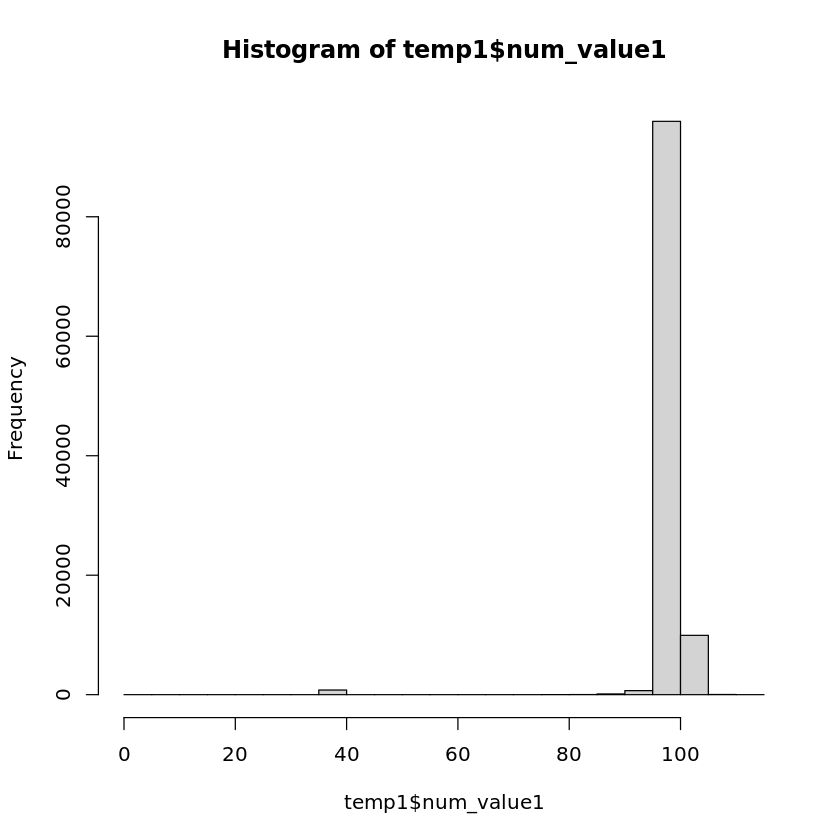

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  95.00   97.90   98.30   98.32   98.60  103.10  107480 

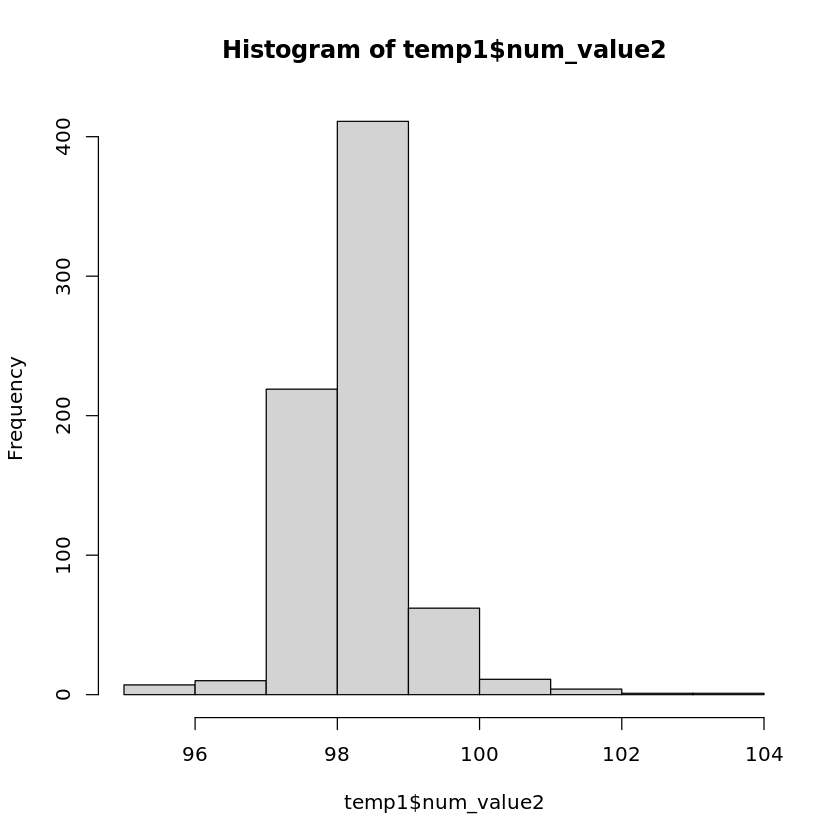

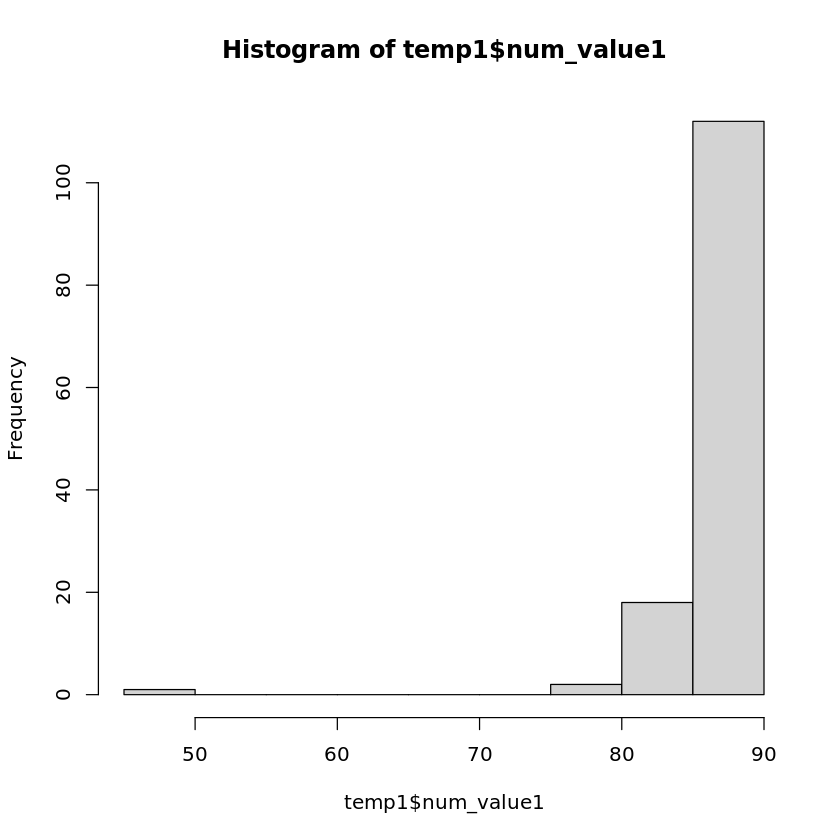

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.1    36.6    36.8    36.8    37.0    48.2 

,num_value1,num_value2
,<dbl>,<dbl>
1,0.1,NA
2,9.4,NA
3,35.0,95.0
4,35.1,95.2
5,35.2,95.4
6,35.5,95.9


[1] 1

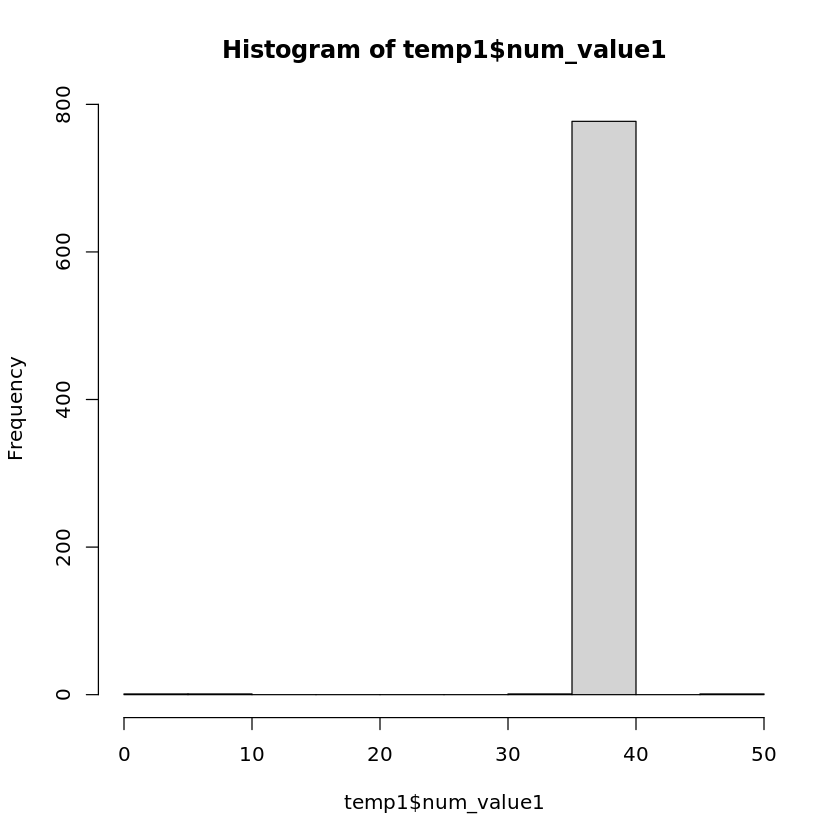

In [38]:
temp1 <- vitals0 %>% filter(row_disp_name == "Temp") %>% select(num_value1, num_value2)
hist(temp1$num_value1)
hist(temp1$num_value2)
summary(temp1$num_value2)

temp1 <- vitals0 %>% filter(row_disp_name == "Temp") %>% select(num_value1, num_value2) %>% filter(num_value1 < 90, num_value1 > 45)
hist(temp1$num_value1)

temp1 <- vitals0 %>% filter(row_disp_name == "Temp") %>% select(num_value1, num_value2) %>% filter(num_value1 < 70) %>%
            arrange(num_value1)
hist(temp1$num_value1)
summary(temp1$num_value1)

head(temp1)

nrow(vitals0 %>% filter(row_disp_name == "Temp") %>% select(num_value1, num_value2) %>% filter(num_value1 < 75, num_value1 > 45))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -17.70   36.60   36.80   36.96   37.20   43.40     353 

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,row_disp_name,units,recorded_time,num_value1,num_value2
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
JC1606941,131242579787,32963756,2017-11-23 03:51:00+00:00,0,Custom Formula Data,Temp (in Celsius),,2017-11-23 01:00:00+00:00,-17.7,NA
JC1794197,131273852266,45350260,2019-07-27 01:04:00+00:00,0,Custom Formula Data,Temp (in Celsius),,2019-07-26 21:27:00+00:00,-12.6,NA
JC1740823,131115241228,21880359,2015-08-26 18:45:00+00:00,1,Custom Formula Data,Temp (in Celsius),,2015-08-26 15:00:00+00:00,2.4,NA
JC1934462,131175721019,23476835,2016-02-13 07:40:00+00:00,0,Custom Formula Data,Temp (in Celsius),,2016-02-13 02:12:00+00:00,2.4,NA
JC1360366,131266090665,41036602,2019-03-19 20:21:00+00:00,0,Custom Formula Data,Temp (in Celsius),,2019-03-19 18:21:00+00:00,2.4,NA
JC1687848,131184920938,24811084,2016-04-28 03:01:00+00:00,0,Custom Formula Data,Temp (in Celsius),,2016-04-28 02:00:00+00:00,2.4,NA
JC1821709,131189332121,25461470,2016-07-06 23:38:00+00:00,0,Custom Formula Data,Temp (in Celsius),,2016-07-06 23:30:00+00:00,2.5,NA
JC743906,131154123054,22898606,2015-11-02 16:06:00+00:00,0,Custom Formula Data,Temp (in Celsius),,2015-11-02 08:55:00+00:00,2.5,NA
JC516616,131305920541,64352093,2021-02-28 05:24:00+00:00,0,Custom Formula Data,Temp (in Celsius),,2021-02-27 22:54:00+00:00,2.5,NA


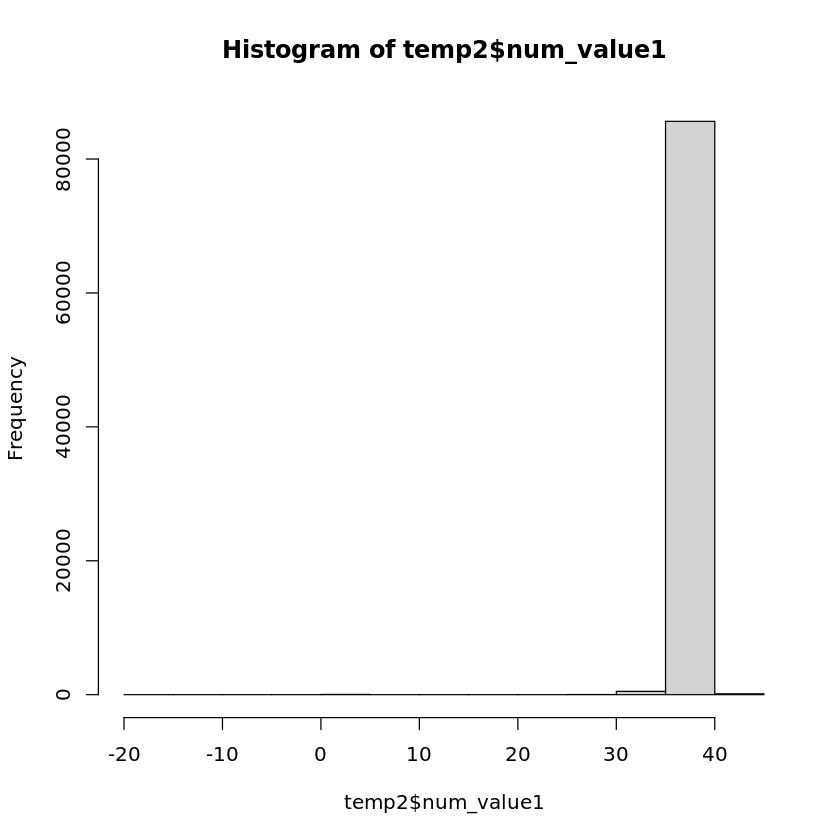

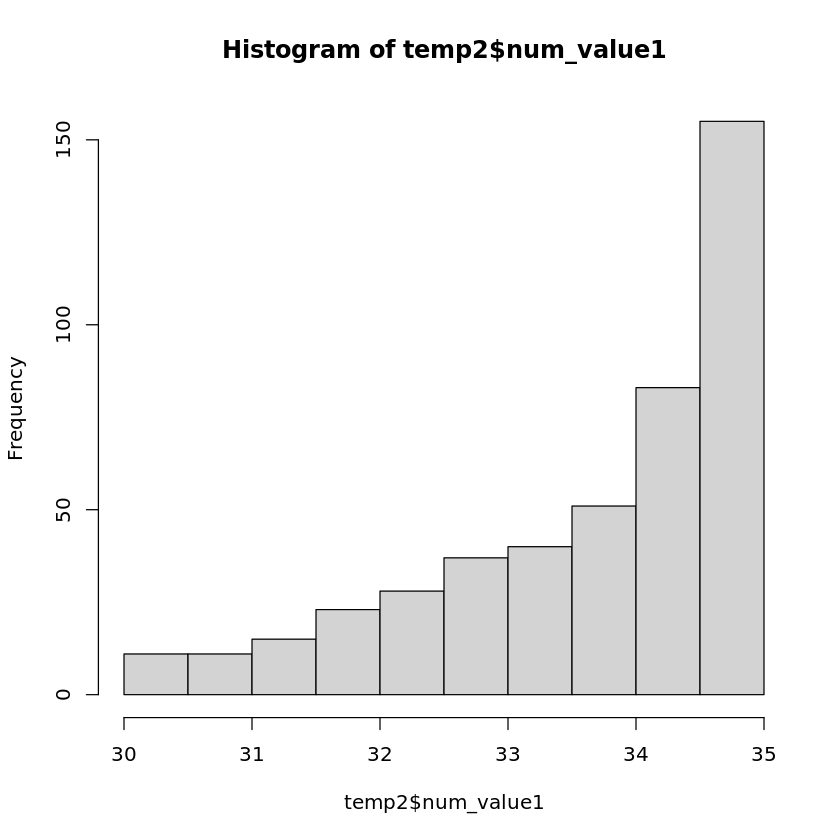

In [39]:
temp2 <- vitals0 %>% filter(row_disp_name == "Temp (in Celsius)")
hist(temp2$num_value1)
summary(temp2$num_value1)

temp2 <- vitals0 %>% filter(row_disp_name == "Temp (in Celsius)", num_value1 < 30)
temp2 %>% arrange(num_value1)

temp2 <- vitals0 %>% filter(row_disp_name == "Temp (in Celsius)", num_value1 < 35, num_value1 >=30)
hist(temp2$num_value1)

In [40]:
# rename the variables, combine similar ones
# only 1 name: SpO2 and BP # ifelse(str_detect(features, paste(GCS, collapse="|")), "GCS",
Pulse = c("Pulse", "Heart Rate") 
RR = c("Resp", "Resp Rate") # not using Respiratory Rate, different scale

# will name BP as SBP and take num_value1 only, DBP will be processed separately
# distinct will reduce many rows, that have values with same recorded time
vitals <- vitals0 %>% rename(features = row_disp_name) %>% 
                mutate(features = ifelse(features == "BP", "SBP",
                                         ifelse(features %in% Pulse, "Pulse", 
                                                ifelse(str_detect(features, "Temp"), "Temp", 
                                                       ifelse(features %in% RR, "RR", as.character(features)))))) %>% # last ... in ifelse(cond, iftrue, ...)
                distinct()
nrow(vitals)       
unique(vitals$features)
fs_feats <- c("Pulse", "RR", "SBP", "Temp")
vitals %>% filter(features %in% fs_feats) %>% group_by(features) %>% display_summary_num1and2(num_value1, num_value2)

[1] 1124808

[1] "RR"    "NIBP"  "SBP"   "Temp"  "Pulse"

features,n,mean1,mean2,median1,median2,min1,min2,max1,max2
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pulse,323493,88.75024,NaN,87.0,NA,0.0,Inf,300.0,-Inf
RR,306832,19.38513,NaN,18.0,NA,0.0,Inf,189.0,-Inf
SBP,299615,128.94987,76.03229,127.0,75.0,0.0,0,419.0,238.0
Temp,194867,70.85898,98.31818,97.5,98.3,-17.7,95,110.2,103.1


### Clean Temp:
- temp in Celsius is above 25 and below 45
- anything < 25 is even less than 10 and considered to be erroneous
- anything > 75 is considered in F 
- num_value2 is only F while num_value1 can be either F or C
- HOWEVER, if num_value1 is NA or num_value1 < 26, there is no num_value2! **So we can just use num_value1 for temp!**

In [41]:
summary(vitals %>% filter(features=="Temp") %>% select(num_value1, num_value2))
nrow(vitals %>% filter(features=="Temp", is.na(num_value1), !is.na(num_value2)))
nrow(vitals %>% filter(features=="Temp", num_value1 <= 25))

   num_value1       num_value2    
 Min.   :-17.70   Min.   : 95.00  
 1st Qu.: 36.90   1st Qu.: 97.90  
 Median : 97.50   Median : 98.30  
 Mean   : 70.86   Mean   : 98.32  
 3rd Qu.: 98.40   3rd Qu.: 98.60  
 Max.   :110.20   Max.   :103.10  
 NA's   :1014     NA's   :194141  

[1] 0

[1] 42

### Check DBP and process this separately, to bind rows afterward

In [42]:
# check DBP (num_value2). Note: BP always have 2 values
nrow(vitals %>% filter(features == "SBP" & is.na(num_value1) & !is.na(num_value2)))
nrow(vitals %>% filter(features == "SBP" & is.na(num_value2) & !is.na(num_value1)))

# display some extrem values of DBP
options(repr.matrix.max.rows=150, repr.matrix.max.cols=20)
vitals %>% filter(features == 'SBP' & (num_value2 > 200 | num_value2 < 25)) %>% arrange(num_value2)

[1] 0

[1] 0

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,num_value1,num_value2
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
JC2870074,131274427714,45720929,2019-08-16 22:09:00+00:00,1,Hemodynamic Measurements,SBP,,2019-08-16 20:31:04+00:00,0,0
JC1511757,131101395078,21385671,2015-07-01 01:38:00+00:00,0,Vitals,SBP,,2015-06-30 14:59:00+00:00,90,0
JC1869136,131106311493,21541326,2015-07-24 09:47:00+00:00,1,Vitals,SBP,,2015-07-24 04:58:29+00:00,110,0
JC1637530,131068992117,19437159,2015-01-21 06:59:00+00:00,0,Vitals,SBP,,2015-01-21 01:42:00+00:00,74,0
JC1637530,131068992117,19437159,2015-01-21 06:59:00+00:00,0,Vitals,SBP,,2015-01-21 01:18:00+00:00,60,0
JC580219,131263588795,39557053,2019-01-20 18:47:00+00:00,1,Vitals,SBP,,2019-01-20 16:47:00+00:00,64,0
JC1637530,131068992117,19437159,2015-01-21 06:59:00+00:00,0,Vitals,SBP,,2015-01-21 06:30:00+00:00,74,0
JC836794,131268077771,42341961,2019-05-31 18:10:00+00:00,0,Vitals,SBP,,2019-05-31 16:30:00+00:00,80,0
JC626762,131066249809,19301550,2015-01-30 11:44:00+00:00,0,IIC VS,SBP,,2015-01-30 11:00:00+00:00,80,0


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0    64.0    75.0    76.1    87.0   238.0  825731 

[1] 28

[1] 69

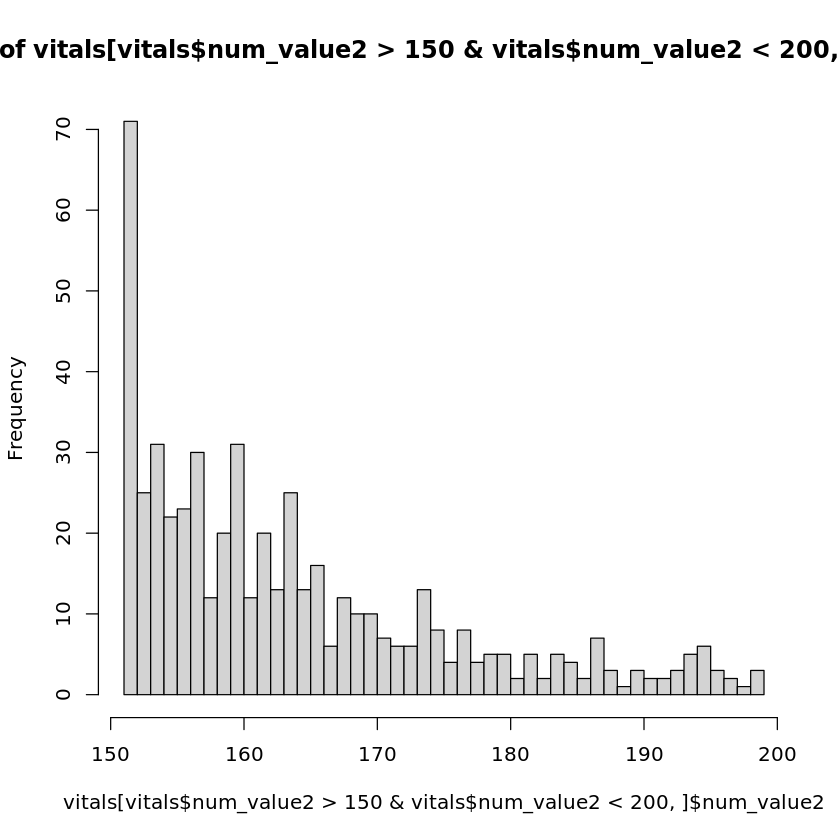

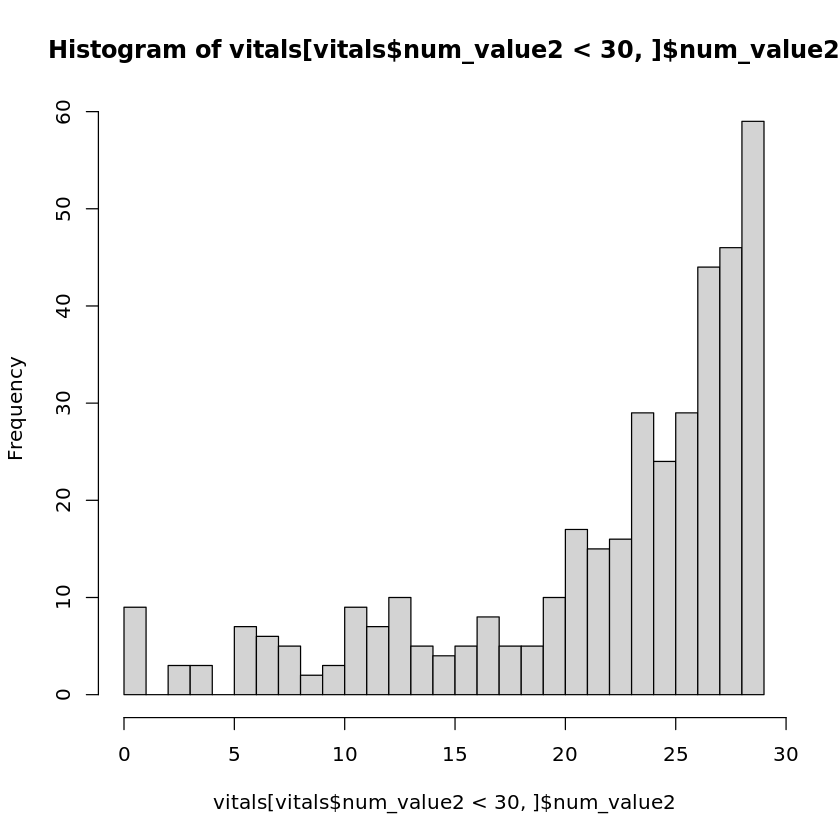

In [43]:
# again, DBP value is num_value2
summary(vitals$num_value2)
nrow(vitals %>% filter(num_value2 > 200))
nrow(vitals %>% filter(num_value2 < 15))

hist(vitals[vitals$num_value2 > 150 & vitals$num_value2 < 200,]$num_value2, breaks =50)
hist(vitals[vitals$num_value2 < 30,]$num_value2, breaks = 30)

### Clean DBP 
- note: rows that are the same except for values: to be taken once --> will do together with other features, take averages!
- consider erroneous values for DBP if SBP > 10*DBP, and if either SBP or DBP = 0
- there's one patient who has duplicated recorded time

[1] 298297

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   64.00   75.00   76.04   86.00  238.00 

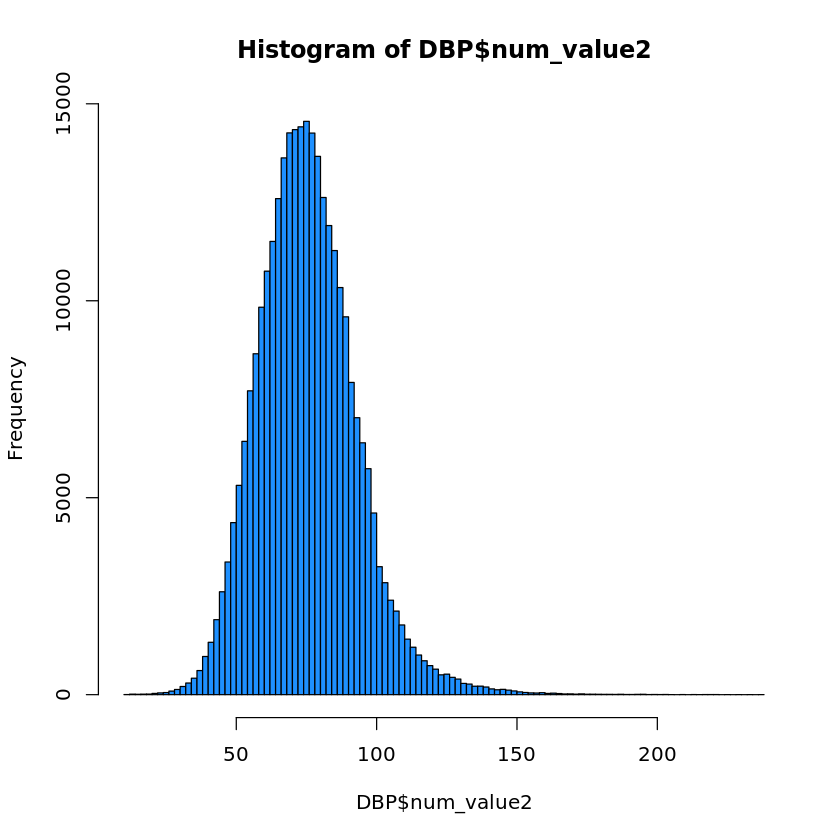

In [44]:
# remove erroneous values for DBP if SBP > 10*DBP, and either SBP or DBP = 0
# will bind rows later --> so ok to filter instead of replacing by NA
DBP <- vitals %>% filter(features == "SBP" & num_value1*num_value2 !=0) %>% 
                    mutate(num_value2 = ifelse(num_value1 > 10*num_value2, NA, num_value2)) %>%
                    drop_na(num_value2) 
nrow(DBP)
summary(DBP$num_value2)
hist(DBP$num_value2, col = "dodgerblue", breaks = 125)

In [45]:
# check DBP and SBP
DBP %>% filter(num_value2 <20) %>% arrange(num_value2)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,num_value1,num_value2
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
JC1071963,131182220877,24403273,2016-03-18 21:35:00+00:00,0,Vitals,SBP,,2016-03-17 16:06:00+00:00,69,10
JC1844774,131251027157,35405253,2018-06-08 02:23:00+00:00,1,DATA VALIDATE,SBP,,2018-06-08 00:42:00+00:00,94,12
JC2972956,131301643291,61707780,2021-02-09 07:03:00+00:00,1,Vitals,SBP,,2021-02-09 01:16:00+00:00,46,12
JC2014076,131199507206,26746668,2016-10-24 11:06:00+00:00,1,Vitals,SBP,,2016-10-24 08:06:00+00:00,102,13
JC1802163,131273610467,45193970,2019-07-02 05:49:00+00:00,1,Vitals,SBP,,2019-07-02 05:15:00+00:00,51,13
JC2769158,131259025143,37945074,2018-11-06 20:05:00+00:00,1,DATA VALIDATE,SBP,,2018-11-06 17:48:00+00:00,35,13
JC1392897,131248642790,34525074,2018-02-24 03:58:00+00:00,0,Vitals,SBP,,2018-02-23 23:40:00+00:00,71,13
JC1108228,131115252104,21882771,2015-10-09 06:45:00+00:00,0,ICU VS,SBP,,2015-10-08 21:30:00+00:00,116,13
JC1361782,131272707003,44615178,2019-08-09 21:08:00+00:00,1,Vitals,SBP,,2019-08-09 17:30:00+00:00,64,13


In [46]:
# change variable name and drop SBP
DBP <- DBP %>% mutate(features = "DBP") %>% select(-c(num_value1)) %>%
                rename(values = num_value2) %>% distinct()

# duplicated row for all columns
nrow(DBP %>% distinct())
DBP[duplicated(DBP), ]

# rows that are the same except for values: to be taken once --> will do together with other features, take average!
DBP %>% group_by_at(vars(-values)) %>% filter(n() > 1) 

[1] 298296

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,DBP,,2019-03-10 10:00:00+00:00,53
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,DBP,,2016-03-13 10:00:00+00:00,77
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,DBP,,2016-03-13 10:00:00+00:00,86
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,DBP,,2017-03-12 10:00:00+00:00,58
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,DBP,,2017-03-12 10:00:00+00:00,72
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,DBP,,2019-03-10 10:00:00+00:00,47


In [47]:
# check BP and other features, note that RR seems to be quite different, maybe take average is better
vitals %>% filter(pat_enc_csn_id_coded == 131265716149, recorded_time == '2019-03-10 10:00:00+00:00') %>%
        arrange(features)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,num_value1,num_value2
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>


[1] 1124138

[1] "Pulse"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   73.00   87.00   88.75  102.00  300.00     785 
[1] "RR"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   16.00   18.00   19.39   21.00  189.00     773 


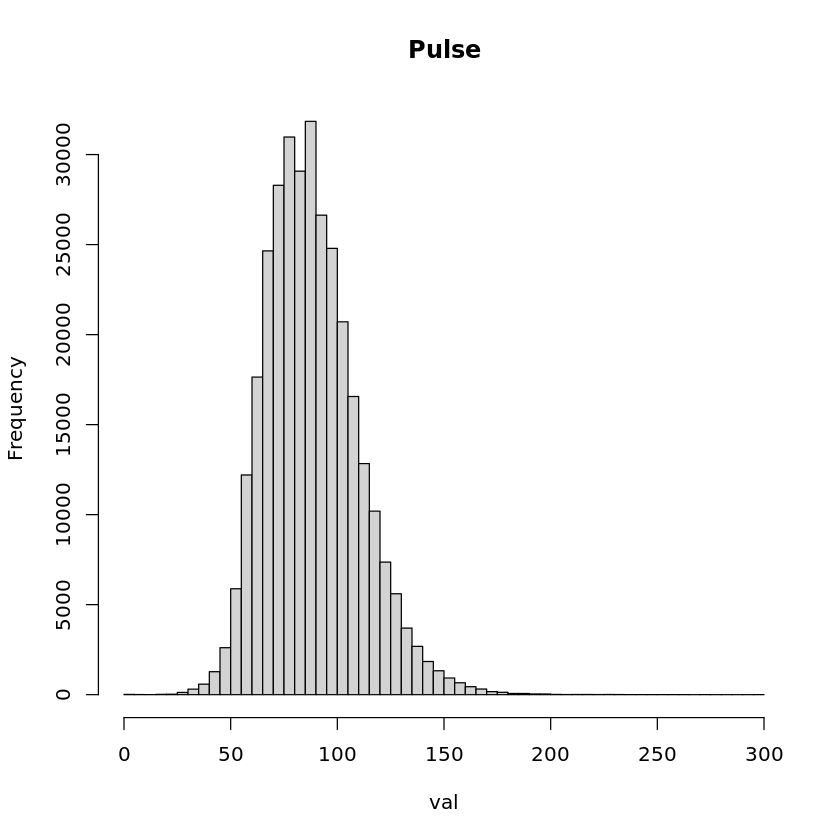

[1] "SBP"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0   111.0   127.0   128.9   145.0   419.0    1265 


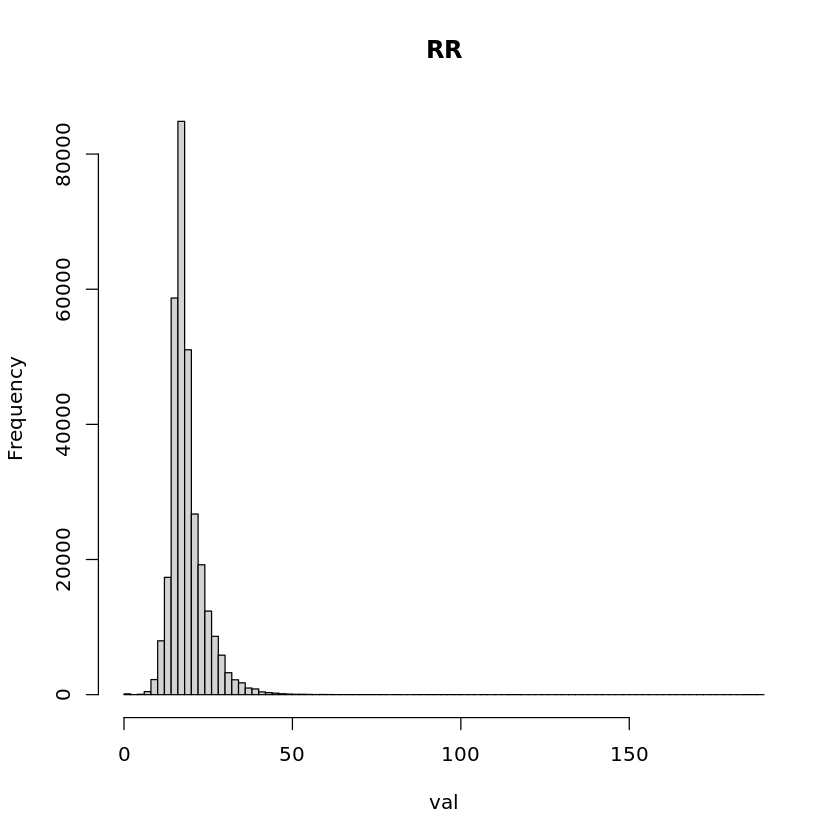

[1] "Temp"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -17.70   36.90   97.50   70.98   98.40  110.20    1014 


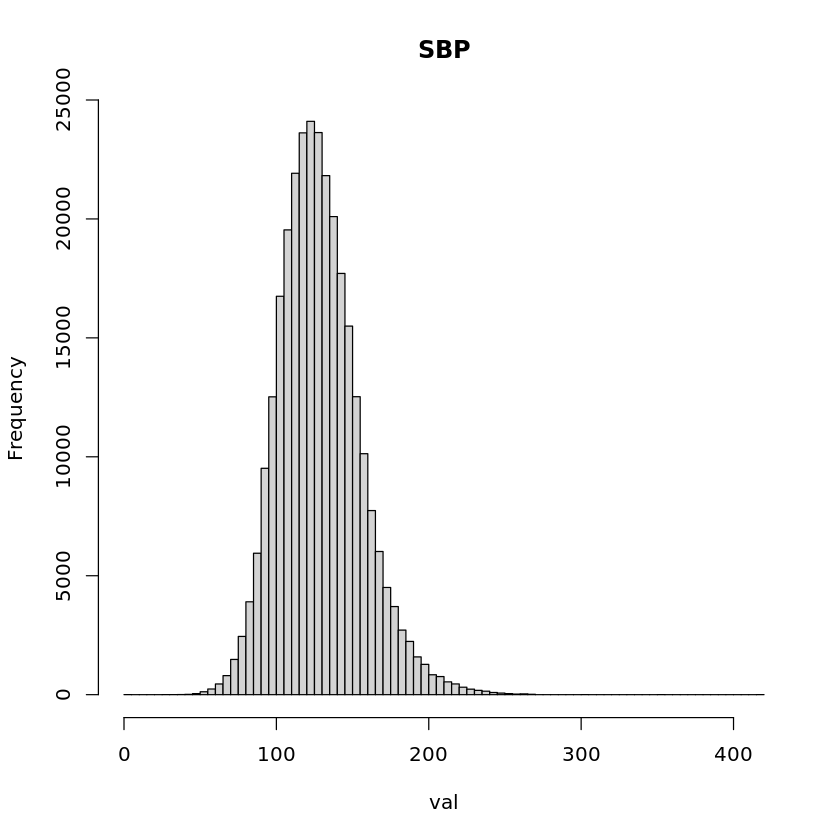

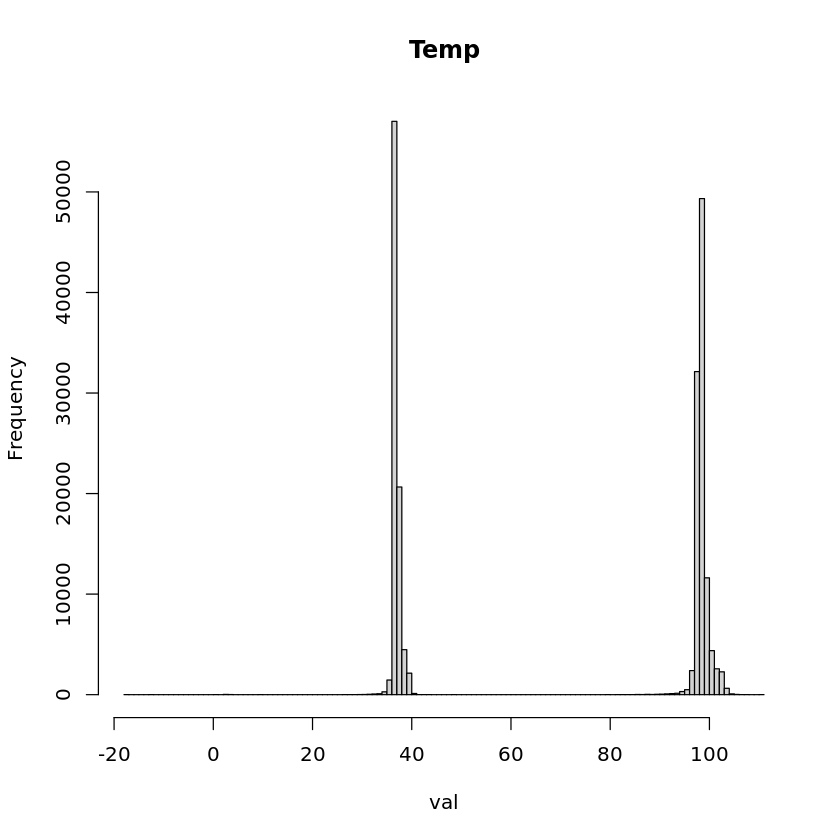

In [48]:
# this set, we look at num_value1 only, no DBP
# keep only variable in the list of VS, all use num_value1
vitals <- vitals %>% filter(features %in% fs_feats) %>%
                        select(-c(num_value2)) %>% rename(values=num_value1) %>% distinct()

# check for distributions of these
nrow(vitals) # 801954 vs 801948
for (f in fs_feats){
    print(f)
    df = vitals %>% select(features, values) %>%  filter(features==f)
    val = df$values
    print(summary(val))
    hist(val, main = f, breaks = 100)
}

### Explore SBP, Pulse, RR

[1] 4

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC2870074,131274427714,45720929,2019-08-16 22:09:00+00:00,1,Hemodynamic Measurements,SBP,,2019-08-16 20:31:04+00:00,0
JC2690491,131304901114,63711374,2021-02-16 16:14:00+00:00,1,Vitals,SBP,,2021-02-16 15:10:00+00:00,30
JC639730,131178765150,23879171,2016-01-29 23:05:00+00:00,1,DATA VALIDATE,SBP,,2016-01-29 20:45:00+00:00,33
JC639730,131178765150,23879171,2016-01-29 23:05:00+00:00,1,Vitals,SBP,,2016-01-29 20:46:51+00:00,33
JC2769158,131259025143,37945074,2018-11-06 20:05:00+00:00,1,DATA VALIDATE,SBP,,2018-11-06 17:48:00+00:00,35
JC579467,131279230382,48757357,2019-12-11 04:32:00+00:00,1,Vitals,SBP,,2019-12-11 03:10:00+00:00,37
JC1663999,131291296700,55393578,2020-06-17 15:47:00+00:00,1,Vitals,SBP,,2020-06-17 14:39:19+00:00,37
JC1410701,131291427619,55474669,2020-07-31 02:28:00+00:00,1,Vitals,SBP,,2020-07-30 23:01:01+00:00,39
JC1807917,131299160281,60196143,2020-11-15 08:43:00+00:00,1,M/S VS,SBP,,2020-11-15 06:02:00+00:00,40


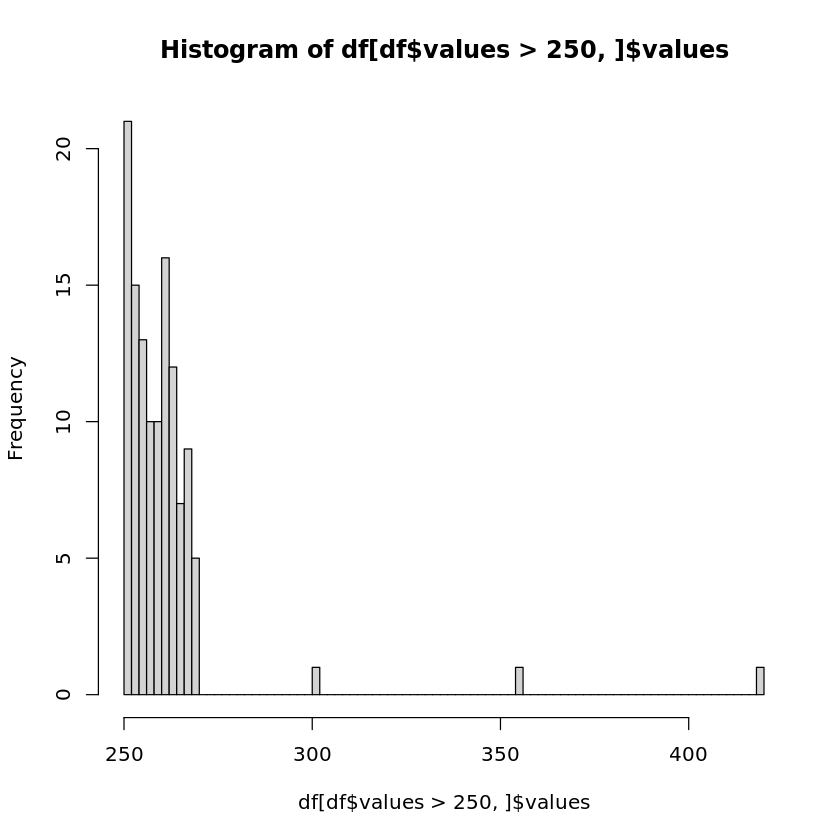

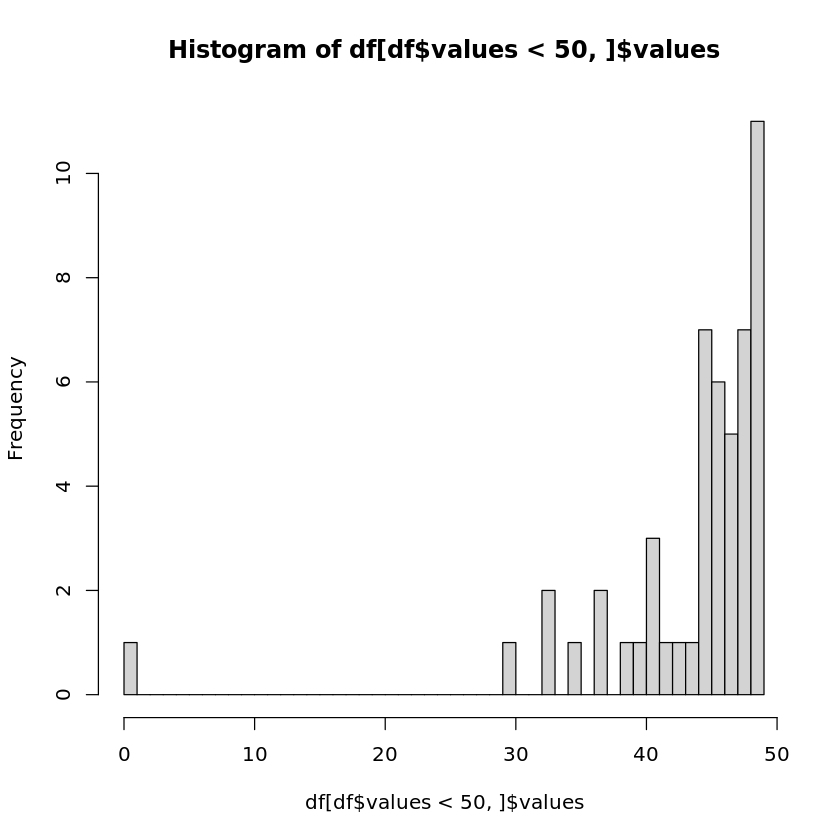

In [49]:
df <- vitals %>% filter(features == "SBP")
nrow(filter(df, values > 310 | values <33))

vitals %>% filter(features == 'SBP' & (values > 300 | values < 50)) %>% arrange(values)

hist(df[df$values > 250,]$values, breaks=100)
hist(df[df$values < 50,]$values, breaks = 50)

[1] 61

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC532911,131185153421,24852175,2016-05-30 09:21:00+00:00,1,ICU VS,Pulse,,2016-05-30 07:46:00+00:00,0
JC772640,131183649862,24619228,2016-05-01 07:55:00+00:00,1,Vitals/Interventions,Pulse,,2016-05-01 06:27:00+00:00,0
JC772640,131183649862,24619228,2016-05-01 07:55:00+00:00,1,Vitals/Interventions,Pulse,,2016-05-01 06:29:00+00:00,0
JC772640,131183649862,24619228,2016-05-01 07:55:00+00:00,1,Vitals/Interventions,Pulse,,2016-05-01 06:23:00+00:00,0
JC1811547,131309382731,66026543,2021-05-08 19:15:00+00:00,1,Vitals,Pulse,,2021-05-08 17:01:44+00:00,0
JC772640,131183649862,24619228,2016-05-01 07:55:00+00:00,1,Vitals/Interventions,Pulse,,2016-05-01 06:25:00+00:00,0
JC772640,131183649862,24619228,2016-05-01 07:55:00+00:00,1,Vitals/Interventions,Pulse,,2016-05-01 06:16:00+00:00,0
JC3014740,131302033796,61941428,2021-02-01 19:02:00+00:00,1,Vitals,Pulse,,2021-02-01 17:04:00+00:00,0
JC772640,131183649862,24619228,2016-05-01 07:55:00+00:00,1,Vitals/Interventions,Pulse,,2016-05-01 06:19:00+00:00,0


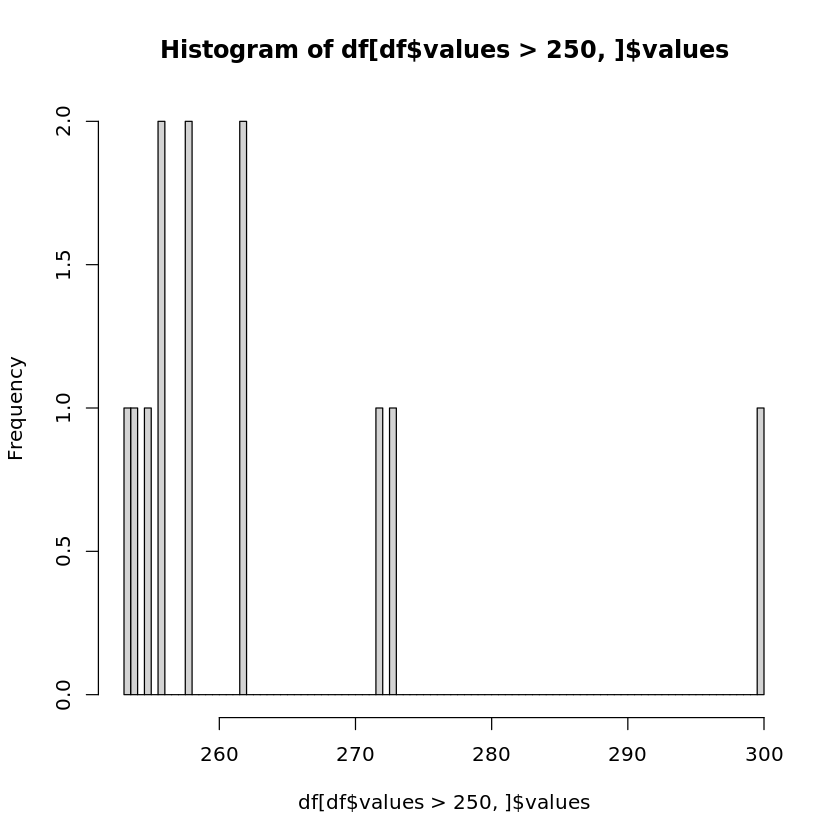

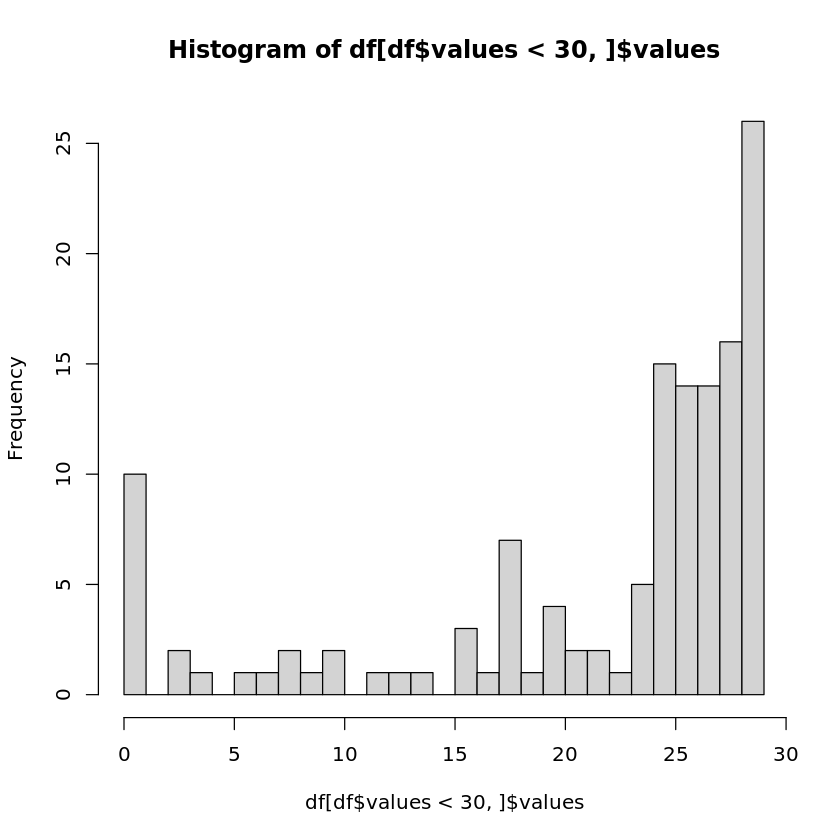

In [50]:
df <- vitals %>% filter(features == "Pulse")
nrow(filter(df, values > 250 | values < 25)) # remove <10 only
filter(df, values > 250 | values < 25) %>% arrange(values)

hist(df[df$values > 250,]$values, breaks=100)
hist(df[df$values < 30,]$values, breaks=25)

[1] 331

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC1900261,131230525726,29937767,2017-06-17 05:16:00+00:00,1,Vitals,RR,,2017-06-17 02:30:00+00:00,1
JC1663999,131115578368,21906454,2015-08-21 08:45:00+00:00,1,Vitals,RR,,2015-08-21 07:59:00+00:00,1
JC1819260,131259219370,38015388,2018-11-11 23:57:00+00:00,0,Vitals,RR,,2018-11-11 20:00:00+00:00,1
JC767171,131274983183,46075392,2019-09-29 05:54:00+00:00,1,ICU VS,RR,,2019-09-29 05:35:00+00:00,1
JC1763735,131316213538,70233733,2021-08-13 23:32:00+00:00,1,Hemodynamic Measurements,RR,,2021-08-13 23:21:16+00:00,1
JC551147,131100576218,21371207,2015-07-16 15:08:00+00:00,0,RT Assess/ Treatment,RR,,2015-07-16 11:48:00+00:00,1
JC1118270,131282708421,50901859,2020-02-03 03:48:00+00:00,0,DATA VALIDATE,RR,bpm,2020-02-03 03:09:00+00:00,2
JC2604443,131288121928,53430400,2020-05-23 14:41:00+00:00,1,DATA VALIDATE,RR,,2020-05-23 12:00:00+00:00,2
JC1786818,131259855944,38244429,2018-12-15 03:50:00+00:00,0,Vitals,RR,,2018-12-15 03:33:00+00:00,2


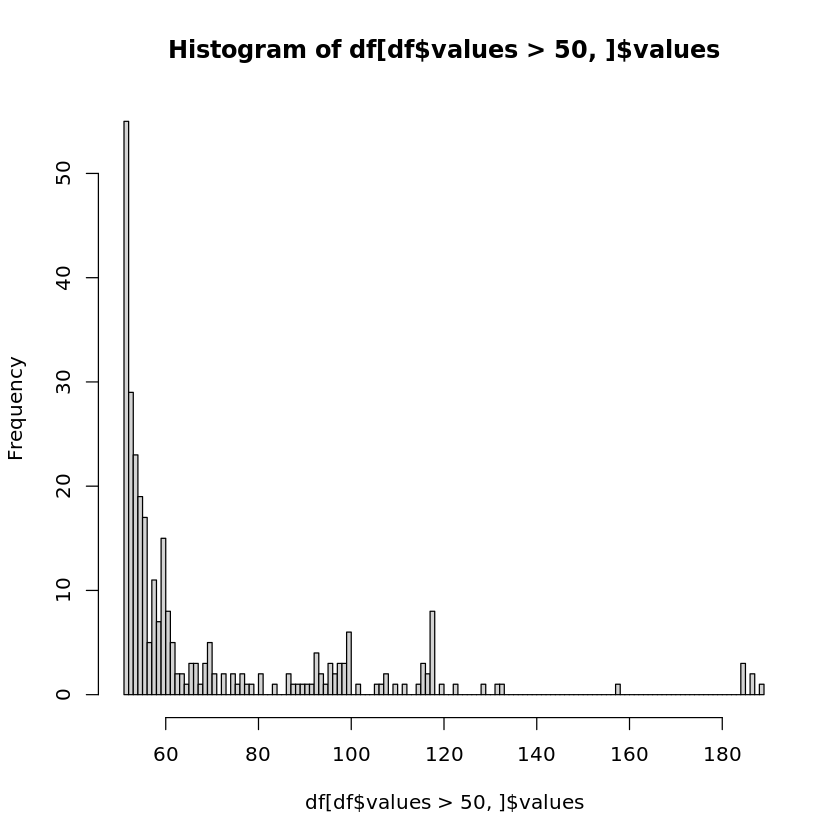

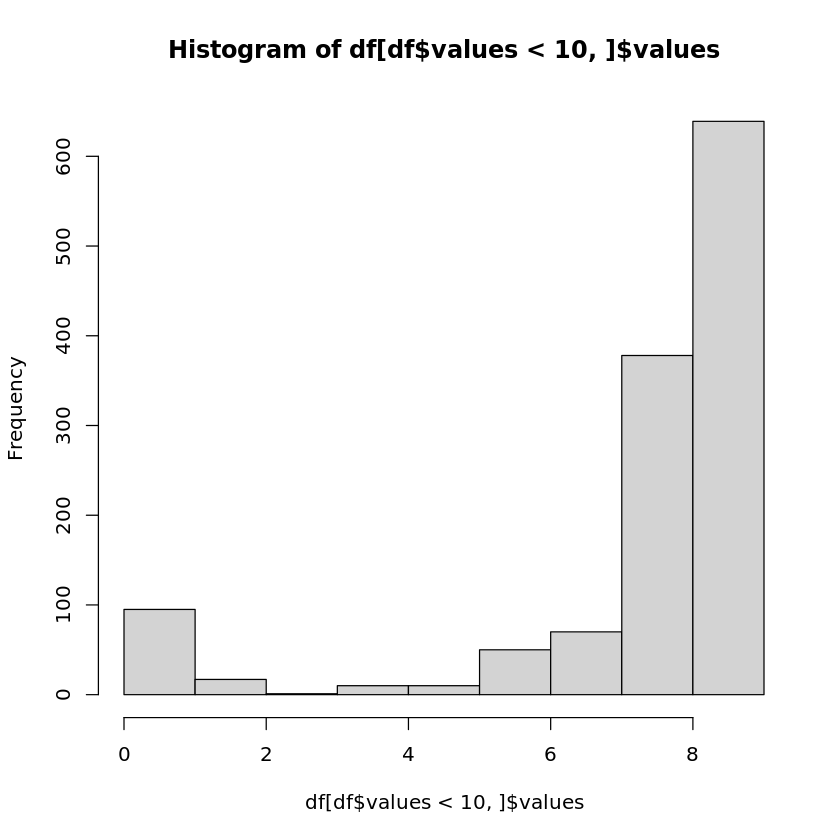

In [51]:
df <- vitals %>% filter(features == "RR")
nrow(filter(df, values > 70 | values < 8))

# there are some 0
filter(df, values > 70 | values < 8 & values > 0) %>% arrange(values)

hist(df[df$values > 50,]$values, breaks=100)
hist(df[df$values < 10,]$values, breaks=10)

In [52]:
unique(vitals$features)
summary(vitals$values)

head(vitals)

[1] "RR"    "SBP"   "Temp"  "Pulse"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -17.70   26.00   86.00   77.44  110.00  419.00    3837 

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
,<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,JC1805086,131311970165,67623416,2021-06-12 17:54:00+00:00,0,DATA VALIDATE,RR,bpm,2021-06-12 05:15:00+00:00,17
2,JC1805086,131311970165,67623416,2021-06-12 17:54:00+00:00,0,DATA VALIDATE,RR,bpm,2021-06-12 04:57:00+00:00,17
3,JC1805086,131311970165,67623416,2021-06-12 17:54:00+00:00,0,DATA VALIDATE,RR,bpm,2021-06-12 05:21:00+00:00,17
4,JC1805086,131311970165,67623416,2021-06-12 17:54:00+00:00,0,DATA VALIDATE,RR,bpm,2021-06-12 05:03:00+00:00,23
5,JC1805086,131311970165,67623416,2021-06-12 17:54:00+00:00,0,DATA VALIDATE,RR,bpm,2021-06-12 05:12:00+00:00,12
6,JC1118270,131282708421,50901859,2020-02-03 03:48:00+00:00,0,DATA VALIDATE,RR,bpm,2020-02-03 03:06:00+00:00,8


### Clean the variables: Temp, SBP, Pulse, and RR

In [53]:
# nothing btwn 45-47, so if > 45 (or actually num_value1 >= 75), convert to C
# replace num_value1 < 20 --> only 2: 0.1 and 9.4 for Temp, and a bunch for Temp(in C)
vitals <- vitals %>% 
            mutate(values=ifelse(features=="Temp",                                  
                                 ifelse(values < 26, NA,
                                         ifelse(values <= 45, values, round((values - 32)*5.0/9.0))), values))

summary(vitals %>% filter(features == "Temp") %>% select(values))

     values     
 Min.   : 9.00  
 1st Qu.:36.70  
 Median :37.00  
 Mean   :36.98  
 3rd Qu.:37.00  
 Max.   :43.40  
 NA's   :1056   

In [54]:
# remove  all NA's, by each feature, as the data is in the long format,
# keep only distinct rows, ok with recorded_time same but different values
vitals <- vitals %>% 
            mutate(values = ifelse(features == "SBP" & values < 30, NA, # < 33 or 30 same effect & > 310 old
                             ifelse(features == "Pulse" & values < 11, NA, # 21 before
                                 ifelse(features == "RR" & (values < 5 | values > 60), NA, # 60 before (tried 70)
                                         ifelse(features == "Temp" & values < 26, NA, values))))) %>%  # 29 before, 26 min here
            drop_na(values) %>% distinct()

nrow(vitals) # 45613
vitals %>% count(features) %>% arrange(-n)
nrow(vitals %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct())

[1] 1119991

features,n
<chr>,<int>
Pulse,322688
RR,305825
SBP,298349
Temp,193129


[1] 62940

[1] "Pulse"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.00   73.00   87.00   88.76  102.00  300.00 
[1] "RR"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   16.00   18.00   19.37   21.00   60.00 


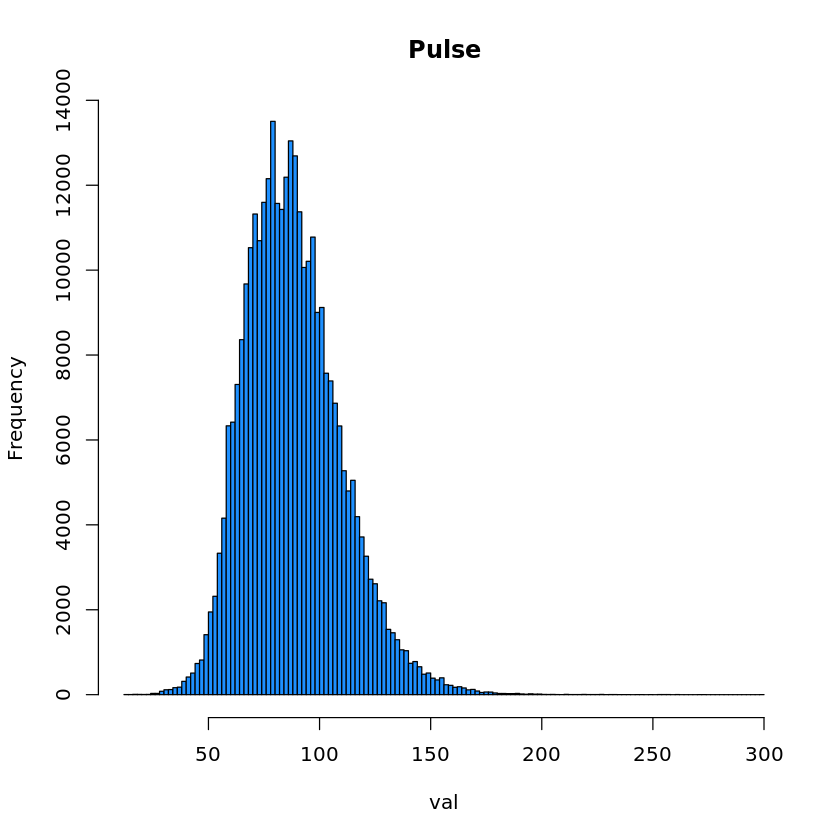

[1] "SBP"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     30     111     127     129     145     419 


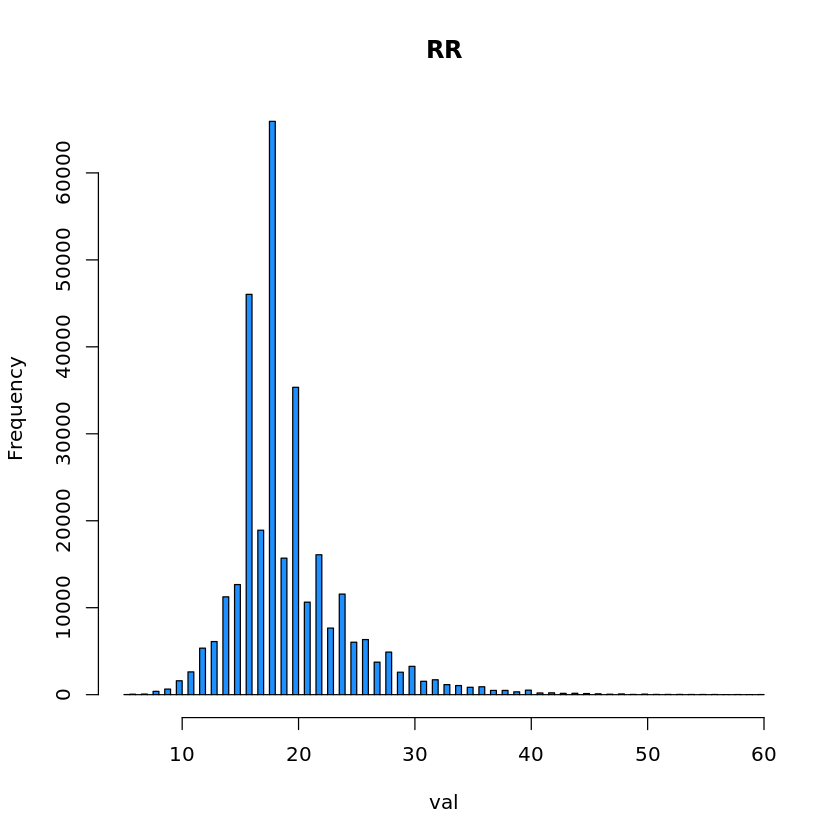

[1] "Temp"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26.00   36.70   37.00   36.98   37.00   43.40 


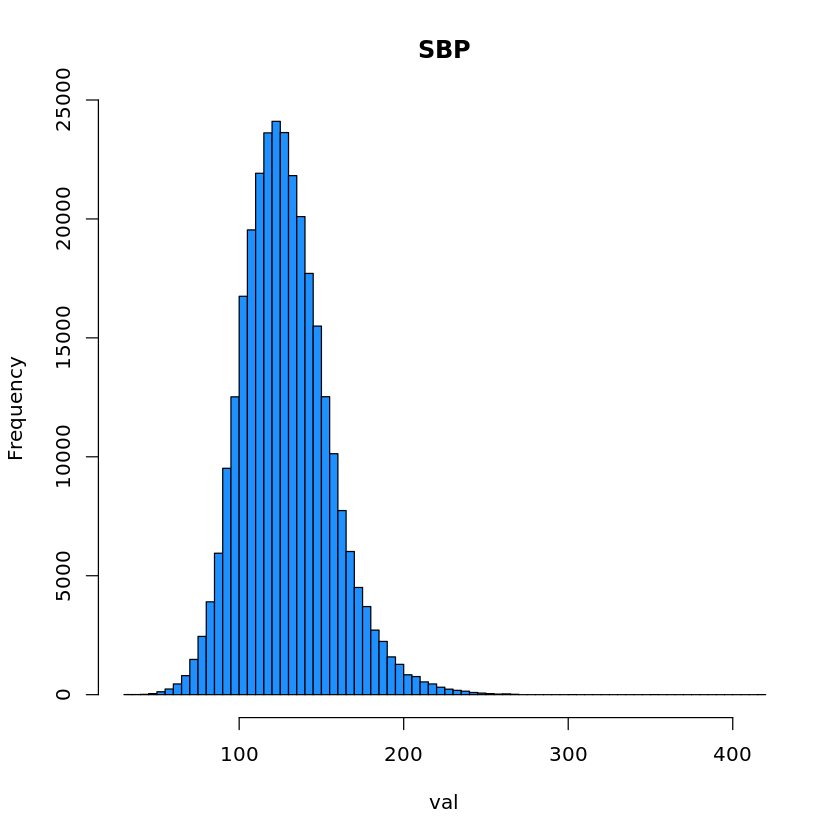

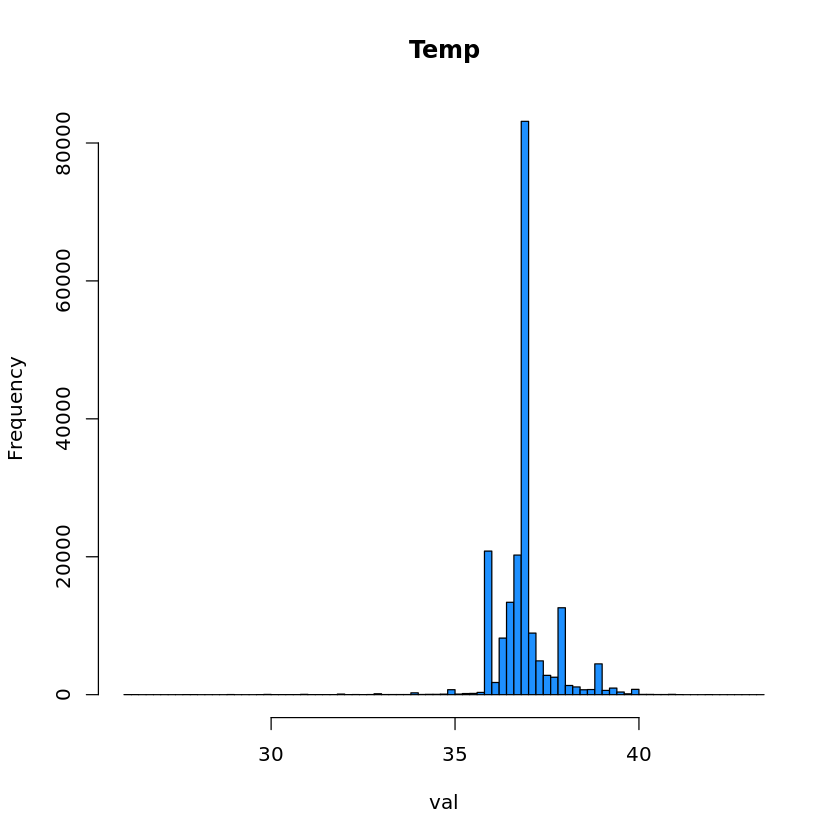

In [55]:
for (f in fs_feats){
    print(f)
    df = vitals %>% select(features, values) %>%  filter(features==f)
    val = df$values
    print(summary(val))
    hist(val, main = f, col="dodgerblue", xlim=c(min(val), max(val)), breaks= 120)
}

In [56]:
# look at duplicates rows with same recorded time, but different values. 
for (f in fs_feats){
    print(f)
    df <- vitals %>% filter(features == f) %>% group_by_at(vars(-values)) %>% filter(n() > 1)
    print(nrow(df))
}

[1] "Pulse"
[1] 8
[1] "RR"
[1] 6
[1] "SBP"
[1] 8
[1] "Temp"
[1] 152


In [57]:
# check for duplicates all but values
DBP %>% group_by_at(vars(-values)) %>% filter(n() > 1) 
vitals %>% filter(features == "SBP") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded)
vitals %>% filter(features == "RR") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded)
vitals %>% filter(features == "Pulse") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded)
vitals %>% filter(features == "Temp") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,DBP,,2019-03-10 10:00:00+00:00,53
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,DBP,,2016-03-13 10:00:00+00:00,77
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,DBP,,2016-03-13 10:00:00+00:00,86
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,DBP,,2017-03-12 10:00:00+00:00,58
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,DBP,,2017-03-12 10:00:00+00:00,72
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,DBP,,2019-03-10 10:00:00+00:00,47


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,SBP,,2016-03-13 10:00:00+00:00,107
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,SBP,,2016-03-13 10:00:00+00:00,113
JC766910,131180583645,24156070,2016-02-28 12:19:00+00:00,0,IIC VS,SBP,,2016-02-28 11:00:00+00:00,117
JC766910,131180583645,24156070,2016-02-28 12:19:00+00:00,0,IIC VS,SBP,,2016-02-28 11:00:00+00:00,100
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,SBP,,2017-03-12 10:00:00+00:00,119
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,SBP,,2017-03-12 10:00:00+00:00,130
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,SBP,,2019-03-10 10:00:00+00:00,82
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,SBP,,2019-03-10 10:00:00+00:00,89


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,RR,,2016-03-13 10:00:00+00:00,35
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,RR,,2016-03-13 10:00:00+00:00,15
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,RR,,2017-03-12 10:00:00+00:00,16
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,RR,,2017-03-12 10:00:00+00:00,15
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,RR,,2019-03-10 10:00:00+00:00,16
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,RR,,2019-03-10 10:00:00+00:00,18


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,Pulse,,2016-03-13 10:00:00+00:00,69
JC711444,131177834885,23749144,2016-03-13 10:10:00+00:00,1,ICU VS,Pulse,,2016-03-13 10:00:00+00:00,86
JC766910,131180583645,24156070,2016-02-28 12:19:00+00:00,0,IIC VS,Pulse,,2016-02-28 11:00:00+00:00,79
JC766910,131180583645,24156070,2016-02-28 12:19:00+00:00,0,IIC VS,Pulse,,2016-02-28 11:00:00+00:00,75
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,Pulse,,2017-03-12 10:00:00+00:00,76
JC2088889,131221950359,29030695,2017-03-12 10:36:00+00:00,0,ICU VS,Pulse,,2017-03-12 10:00:00+00:00,73
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,Pulse,,2019-03-10 10:00:00+00:00,91
JC2818408,131265367930,40548944,2019-03-10 10:45:00+00:00,0,Vitals,Pulse,,2019-03-10 10:00:00+00:00,96


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC582156,131262009998,39008003,2019-02-08 20:35:00+00:00,0,Custom Formula Data,Temp,,2019-02-08 11:30:00+00:00,37.0
JC582156,131262009998,39008003,2019-02-08 20:35:00+00:00,0,Custom Formula Data,Temp,,2019-02-08 11:30:00+00:00,36.9
JC1794617,131262467454,39159873,2019-02-04 05:44:00+00:00,0,Custom Formula Data,Temp,,2019-02-04 05:09:00+00:00,37.0
JC1794617,131262467454,39159873,2019-02-04 05:44:00+00:00,0,Custom Formula Data,Temp,,2019-02-04 05:09:00+00:00,36.6
JC523460,131262755657,39260327,2019-02-16 06:01:00+00:00,0,Custom Formula Data,Temp,,2019-02-16 04:22:00+00:00,38.0
JC523460,131262755657,39260327,2019-02-16 06:01:00+00:00,0,Custom Formula Data,Temp,,2019-02-16 04:22:00+00:00,37.5
JC2800194,131263055091,39367299,2019-02-15 05:03:00+00:00,0,Custom Formula Data,Temp,,2019-02-15 04:15:00+00:00,37.0
JC2800194,131263055091,39367299,2019-02-15 05:03:00+00:00,0,Custom Formula Data,Temp,,2019-02-15 04:15:00+00:00,36.7
JC2724389,131267455088,41935776,2019-05-21 03:16:00+00:00,0,Custom Formula Data,Temp,,2019-05-21 02:53:00+00:00,37.0


### Combined DBP back to VS!

In [58]:
head(DBP, n=1)
head(vitals, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
,<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,JC522000,131079845476,19987305,2015-04-02 14:19:00+00:00,0,Vitals,DBP,,2015-04-02 11:43:00+00:00,80


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,values
,<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,JC1805086,1.31312e+11,67623416,2021-06-12 17:54:00+00:00,0,DATA VALIDATE,RR,bpm,2021-06-12 05:15:00+00:00,17


In [59]:
nrow(DBP)
nrow(vitals)
nrow(cohort) #45794

vitals <- bind_rows(vitals, DBP) %>% mutate(feature_type = "vitals") 
summary(vitals$values)
nrow(vitals) 
nrow(vitals %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) #45613

[1] 298296

[1] 1119991

[1] 63050

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   36.70   72.00   72.52  102.00  419.00 

[1] 1418287

[1] 62940

In [60]:
# list the duplicated rows (except values) again
dup <- vitals %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded, features)

In [61]:
nrow(dup)
dup_avg <- dup %>% group_by_at(vars(-values)) %>% summarise(values = mean(values))
nrow(dup_avg)

[1] 180

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'admit_time', 'label', 'template', 'features', 'units', 'recorded_time'. You can override using the `.groups` argument.



[1] 90

In [62]:
# for those duplicated rows, take averages of values
cohort_vitals <- vitals %>% group_by_at(vars(-values)) %>% summarise(values = mean(values))
nrow(vitals)
nrow(cohort_vitals)

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'admit_time', 'label', 'template', 'features', 'units', 'recorded_time'. You can override using the `.groups` argument.



[1] 1418287

[1] 1418197

In [63]:
head(cohort_vitals, n=1)
summary(cohort_vitals$values)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,feature_type,values
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,ICU Intake & Output,DBP,,2015-01-27 07:30:00+00:00,vitals,57


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   36.70   72.00   72.53  102.00  419.00 

In [64]:
# save cohort vital signs after cleaning, no NA's here, has recorded time, used for binning
write.csv(cohort_vitals, file.path(outdir, "5_coh2_vitals.csv"), row.names=FALSE)

## Part 2. Get the first set of vital signs - UPDATE COHORT 
This will result in an updated (smaller) cohort, `1_3_cohort`, only with observations whose have at least a complet set of vital signs.

These blocks of code in this section are the same in:
- `1_cohort/1.5_cohort_complete1vitals_R.ipynb`
- second part of the `2.3_vitalsigns_R.ipynb`

In [65]:
# read inputs
datadir = "../../DataTD/shc2021"
outdir = "../../OutputTD/shc2021"

cohort_vitals <- read.csv(file.path(outdir, "5_coh2_vitals.csv"))
nrow(cohort_vitals)
length(unique(cohort_vitals$pat_enc_csn_id_coded))

[1] 1418197

[1] 62940

In [66]:
head(cohort_vitals)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,template,features,units,recorded_time,feature_type,values
,<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,ICU Intake & Output,DBP,,2015-01-27 07:30:00+00:00,vitals,57
2,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,ICU Intake & Output,SBP,,2015-01-27 07:30:00+00:00,vitals,105
3,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,ICU VS,DBP,,2015-01-27 07:00:00+00:00,vitals,65
4,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,ICU VS,DBP,,2015-01-27 08:00:00+00:00,vitals,58
5,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,ICU VS,DBP,,2015-01-27 12:00:00+00:00,vitals,64
6,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,ICU VS,Pulse,,2015-01-27 07:00:00+00:00,vitals,70


In [67]:
# same as above, but takes ~8min to run
vs1st <- cohort_vitals %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                                  admit_time, label, recorded_time, features, values, feature_type) %>% 
            mutate(recorded_time = ymd_hms(recorded_time)) %>% 
            group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                     admit_time, label, features) %>%
            top_n(n=-1, recorded_time) %>% # slice_min(n=1, recorded_time, with_ties = FALSE) 
            summarise(first_val = mean(values, na.rm=TRUE)) %>% distinct()

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'admit_time', 'label'. You can override using the `.groups` argument.



In [68]:
# only have 1 unique time because we already took care of this 
nrow(vs1st) #
nrow(vs1st %>% distinct(anon_id, pat_enc_csn_id_coded, features))
nrow(vs1st %>% distinct(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded)) # 
nrow(vs1st %>% distinct(anon_id, pat_enc_csn_id_coded))

[1] 312692

[1] 312692

[1] 62940

[1] 62940

In [69]:
write.csv(vs1st, file.path(outdir, "5_coh2_vs1st.csv"), row.names=FALSE)

In [70]:
# note: cohort size dropped further, new size 44258!
# get the the cohort with 1st complete set of VS for ESI imputation
cohort1vs <- vs1st %>% drop_na() %>% spread(features, first_val) %>% drop_na() 
colnames(cohort1vs)
nrow(cohort1vs %>% distinct(pat_enc_csn_id_coded))

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"

[1] 61176

In [71]:
# updated/reduced size of 44258
write.csv(cohort1vs, file.path(outdir, "5_cohort3.csv"), row.names=FALSE)

## Part 3. Get other VS related features for the simple data/model: 

- Vital signs: first and last values, summary statistics, difference from last - first and max - min
- Updated cohort only contains those with at least a complete set of vital signs

Note that first and last values at the same time might have more than 1. However, this was taken care of during the processing of vital signs, when we took the averages if there are multiple values at the same recorded_time

In [72]:
# read inputs
outdir = "../../OutputTD/shc2021"

cohort1vs <- read.csv(file.path(outdir, "5_cohort3.csv"))
cohort_vitals <- read.csv(file.path(outdir, "5_coh2_vitals.csv"))

In [73]:
nrow(cohort1vs)
nrow(cohort1vs %>% drop_na() %>% distinct())
nrow(cohort1vs %>% distinct(pat_enc_csn_id_coded)) #44258

nrow(cohort_vitals)
nrow(cohort_vitals %>% drop_na() %>% distinct()) #1011224
nrow(cohort_vitals %>% distinct(pat_enc_csn_id_coded)) #45613

[1] 61176

[1] 61176

[1] 61176

[1] 1418197

[1] 1418197

[1] 62940

In [74]:
head(cohort1vs, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,75,79,18,127,37


In [75]:
# get the most recent value of each feature, top_n(n=1, recorded_time) or slice_max
vs_last <- cohort_vitals %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                                    admit_time, label, recorded_time, features, values, feature_type) %>% 
            group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, admit_time, label, features) %>%
            top_n(n=1, recorded_time) %>%
            summarise(last_val = mean(values, na.rm=TRUE)) %>% distinct() # %>% 
#             drop_na() %>% spread(features, last_val) %>% drop_na() 

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'admit_time', 'label'. You can override using the `.groups` argument.



In [76]:
# only have 1 unique time because we already took care of this 
nrow(vs_last) #
nrow(vs_last %>% distinct(anon_id, pat_enc_csn_id_coded))
nrow(vs_last %>% distinct(pat_enc_csn_id_coded)) #

[1] 312692

[1] 62940

[1] 62940

In [77]:
# check cohortID not in vitals as cohortIDs were derived before getting vitals
# nrow(cohort %>% filter(!anon_id %in% vs1st$anon_id))

In [78]:
nrow(cohort1vs) # UPDATED cohort, this is after dropping those w/o a complete VS set
nrow(vs1st %>% distinct(pat_enc_csn_id_coded)) # prior to dropping those w/o ..
nrow(vs_last) # prior to dropping those w/o ..

nrow(cohort_vitals %>% distinct(pat_enc_csn_id_coded)) # all vitals
colnames(cohort1vs); colnames(vs1st); colnames(vs_last); colnames(cohort_vitals)

[1] 61176

[1] 62940

[1] 312692

[1] 62940

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "admit_time"             
[5] "label"                   "features"               
[7] "first_val"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "admit_time"             
[5] "label"                   "features"               
[7] "last_val"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "template"               
 [7] "features"                "units"                  
 [9] "recorded_time"           "feature_type"           
[11] "values"

In [79]:
# join the updated cohort - cohort1vs (with a complete set of VS), first, last, and the rest of values for vitals
coh3_vitals <- cohort1vs %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, admit_time, label) %>%
                left_join(vs1st) %>% left_join(vs_last) %>% left_join(cohort_vitals) %>%
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, admit_time, label,
                       features, first_val, last_val, values, feature_type)
nrow(coh3_vitals)# 987224
coh3_vitals %>% group_by(features) %>% count()

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time", "label")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time", "label", "features")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time", "label", "features")



[1] 1385714

features,n
<chr>,<int>
DBP,290580
Pulse,314538
RR,297677
SBP,290626
Temp,192293


In [80]:
nrow(coh3_vitals) # 987260 vs now 987224
nrow(coh3_vitals %>% distinct(pat_enc_csn_id_coded)) #44258
sum(!coh3_vitals$pat_enc_csn_id_coded %in% cohort1vs$pat_enc_csn_id_coded)
table(coh3_vitals$feature_type)
head(coh3_vitals, n=1)

[1] 1385714

[1] 61176

[1] 0


 vitals 
1385714 

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,features,first_val,last_val,values,feature_type
,<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,DBP,75,62,57,vitals


In [81]:
# get summary stats, including differences for first and last (0 if 1 value), min and max
# all the NA were actually already dropped, so na.rm here is redundant
vsum <- coh3_vitals %>% 
            group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                     admit_time, label, features, first_val, last_val) %>%
            summarise(count = n(), meanx = mean(values, na.rm=TRUE), medianx = median(values, na.rm=TRUE), 
                      minx = min(values, na.rm=TRUE), maxx = max(values, na.rm=TRUE), sdx = sd(values, na.rm=TRUE),
                      madx = mad(values, na.rm=TRUE), IQRx = IQR(values, na.rm=TRUE)) %>%
            mutate(mmdiff = round(maxx - minx, 1), fldiff = round(last_val - first_val, 1)) #

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'admit_time', 'label', 'features', 'first_val'. You can override using the `.groups` argument.



In [82]:
head(vsum, n=1)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,features,first_val,last_val,count,meanx,medianx,minx,maxx,sdx,madx,IQRx,mmdiff,fldiff
<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,DBP,75,62,19,61.84211,62,54,75,4.958306,2.9652,6.5,21,-13


In [83]:
nrow(vsum) #
colnames(vsum)
unique(vsum$features)
summary(vsum)

[1] 305880

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "features"               
 [7] "first_val"               "last_val"               
 [9] "count"                   "meanx"                  
[11] "medianx"                 "minx"                   
[13] "maxx"                    "sdx"                    
[15] "madx"                    "IQRx"                   
[17] "mmdiff"                  "fldiff"

[1] "DBP"   "Pulse" "RR"    "SBP"   "Temp"

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:305880      Min.   :1.311e+11    Min.   :18839023       
 Class :character   1st Qu.:1.312e+11    1st Qu.:27953819       
 Mode  :character   Median :1.313e+11    Median :38213386       
                    Mean   :1.312e+11    Mean   :41278920       
                    3rd Qu.:1.313e+11    3rd Qu.:54135994       
                    Max.   :1.313e+11    Max.   :73231043       
                                                                
  admit_time            label          features           first_val     
 Length:305880      Min.   :0.0000   Length:305880      Min.   :  6.00  
 Class :character   1st Qu.:0.0000   Class :character   1st Qu.: 36.80  
 Mode  :character   Median :0.0000   Mode  :character   Median : 71.00  
                    Mean   :0.1347                      Mean   : 71.96  
                    3rd Qu.:0.0000                      3rd Qu.:103.00  
                    Max.   :1.0000        

In [84]:
# replace na of sdx (due to denominator of n-1) as 0
# wide to long on multiple cols to wide
# remove rows with any na --> only complete cases of 1 set of vital signs
vsum_wide <- vsum %>% mutate(sdx = ifelse(is.na(sdx), 0, sdx)) %>%
                gather(variable, value, first_val:fldiff) %>%
                unite(temp, features, variable) %>%
                spread(temp, value) %>% drop_na()

In [85]:
nrow(vsum_wide) #
nrow(vsum_wide %>% select(pat_enc_csn_id_coded) %>% distinct()) 
colnames(vsum_wide)
summary(vsum_wide)

[1] 61176

Adding missing grouping variables: `anon_id`, `inpatient_data_id_coded`, `admit_time`, `label`



[1] 61176

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP_count"              
 [7] "DBP_first_val"           "DBP_fldiff"             
 [9] "DBP_IQRx"                "DBP_last_val"           
[11] "DBP_madx"                "DBP_maxx"               
[13] "DBP_meanx"               "DBP_medianx"            
[15] "DBP_minx"                "DBP_mmdiff"             
[17] "DBP_sdx"                 "Pulse_count"            
[19] "Pulse_first_val"         "Pulse_fldiff"           
[21] "Pulse_IQRx"              "Pulse_last_val"         
[23] "Pulse_madx"              "Pulse_maxx"             
[25] "Pulse_meanx"             "Pulse_medianx"          
[27] "Pulse_minx"              "Pulse_mmdiff"           
[29] "Pulse_sdx"               "RR_count"               
[31] "RR_first_val"            "RR_fldiff"              
[33] "RR_IQRx"                 "RR_last_val"            
[35] "RR_madx"                 "RR_maxx"                
[37] "RR_meanx"                "RR_medianx"             
[39] "RR_minx"                 "RR_mmdiff"              
[41] "RR_sdx"                  "SBP_count"              
[43] "SBP_first_val"           "SBP_fldiff"             
[45] "SBP_IQRx"                "SBP_last_val"           
[47] "SBP_madx"                "SBP_maxx"               
[49] "SBP_meanx"               "SBP_medianx"            
[51] "SBP_minx"                "SBP_mmdiff"             
[53] "SBP_sdx"                 "Temp_count"             
[55] "Temp_first_val"          "Temp_fldiff"            
[57] "Temp_IQRx"               "Temp_last_val"          
[59] "Temp_madx"               "Temp_maxx"              
[61] "Temp_meanx"              "Temp_medianx"           
[63] "Temp_minx"               "Temp_mmdiff"            
[65] "Temp_sdx"

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:61176       Min.   :1.311e+11    Min.   :18839023       
 Class :character   1st Qu.:1.312e+11    1st Qu.:27953819       
 Mode  :character   Median :1.313e+11    Median :38213386       
                    Mean   :1.312e+11    Mean   :41278920       
                    3rd Qu.:1.313e+11    3rd Qu.:54135994       
                    Max.   :1.313e+11    Max.   :73231043       
  admit_time            label          DBP_count     DBP_first_val   
 Length:61176       Min.   :0.0000   Min.   : 1.00   Min.   : 12.00  
 Class :character   1st Qu.:0.0000   1st Qu.: 2.00   1st Qu.: 67.00  
 Mode  :character   Median :0.0000   Median : 3.00   Median : 78.00  
                    Mean   :0.1347   Mean   : 4.75   Mean   : 78.33  
                    3rd Qu.:0.0000   3rd Qu.: 6.00   3rd Qu.: 89.00  
                    Max.   :1.0000   Max.   :67.00   Max.   :219.00  
   DBP_fldiff          DBP_IQRx        DBP_last_val    

In [86]:
# 44258
write.csv(vsum_wide, file.path(outdir, "5_coh3_vital_stats.csv"), row.names=FALSE)